# Collect some tweets from Twitter
We use snscrape library to retrieve tweets from twitter, and since the project is about classifying the tweets as offensive and non-offensive, we restricted our search by using a list of words and phrases (it will give us only the tweets that contains one or more of these words and phrases). Then, we used pandas to save these tweets as a csv file.

```python

import snscrape.modules.twitter as sntwitter
import pandas as pd
import tqdm             # to show the progress of the operation

queries = ['flower', 'plant', 'cloud', 'montain', 'sea', 'moon', 'sand',
           'motherfucker', 'dickhead', 'dick','fat', 'suck my dick',
           'fucker', 'kill your self', 'niggers', 'bang your mom',
           'whore', 'fuck you','hope you die', 'just die', 'death',
           'kill', 'fuck', 'shit', 'pussy', 'cancer', 'love','hate',
           'moron', 'balls', 'suck my balls', 'rape', 'asshole','bitch']
tweets = []
limit = 1500   # for each phrase or word

for query in tqdm.tqdm(queries):
    count = 0
    #search tweets for each word or phrase from the list at a time
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():     
        if count  == limit:
            break
        else:
            # using just the content (text)of the tweet
            tweets.append([tweet.content])
            count += 1

df = pd.DataFrame(tweets, columns = ['Tweet'])

df.to_csv('n_data.csv', index = False)
```

# Data preprocessing
In this stage and after labeling the tweets manually, we start to clean the data to be used it in our models. First, we remove the usernames and website addresses and any links (contents that do not provide any information to our model) from the tweets, and add these tweets to the empty Dataframe that we created using pandas. Next, we eliminate the duplications and null values from our Dataframe. The model cannot work on tweets with different languages so we use LangeDetect library to recognize and eliminate the non-English words and phrases from tweets. Now our dataset is preprocessed and ready to be used in our model.

```python

import pandas as pd
from langdetect import detect
import tqdm

df = pd.read_csv('data.csv')

# create an empty Dataframe
prep_df = pd.DataFrame(columns =['Tweet', 'Label'])

print("Deleting users name and urls:")

for tweet in tqdm.tqdm(df['Tweet']):
    tweet_words = []
    for word in str(tweet).split(' '):
        if word.startswith('@'):   # removing usernames
            word = ''
        elif word.startswith('http'):   # removing websites links
            word = ''
        elif word.startswith('https'):
            word = ''
        tweet_words.append(word)
    prep_tweet = " ".join(tweet_words)    
    # adding the cleaned tweets to the empty Dataframe
    prep_df = pd.concat( [prep_df, pd.DataFrame({"Tweet": [prep_tweet],
                                                 "Label": 0})],
                        ignore_index = True)

prep_df = prep_df.drop_duplicates()      # deleting the repeated tweets

prep_df = prep_df.dropna()               # delete the null values

print("Deleting non english tweets:")

tweets = prep_df['Tweet']

for tweet in tqdm.tqdm(prep_df['Tweet']):
    try:
        language = detect(tweet)  # to detect the language of the text
    except:
        prep_df = prep_df[prep_df['Tweet']!=tweet]
        continue
    if language != 'en':
        # removing the non-English tweets
        prep_df = prep_df[prep_df['Tweet']!=tweet]

print("Number of total preprocessed data:", len(prep_df))

prep_df = prep_df.drop_duplicates(subset=['Tweet'])

prep_df.to_csv('prep_data.csv', index = False)
```

# Working on the classification models

## Importing all the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, PredefinedSplit

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk import word_tokenize; nltk.download('punkt')
nltk.download('stopwords')

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline


from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

[nltk_data] Downloading package punkt to /home/jrhin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jrhin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the labeled data

In [2]:
data = pd.read_csv('labeled_data.csv')  

## Visualizating the data
shows how the data distributed, as it can be seen we have almost an balanced data. The chart shows the percentage of the two categories, 51.5% (a bit more than the half) of the data are labeles as non-offensive and 48.5% are as offensive, which means they are almost evenly distributed.

,Tweet,Label
0,"in the spirit of gender equality, i will now b...",0.0
1,motherfucker really said “do me a favor”,1.0
2,"About is about perspective they say, but in a...",1.0
3,40 fucks in mine! 11 goddamns. 21 shits. And...,1.0
4,Motherfucker you are exactly the reason why p...,1.0


Number of tweets: 17736
Distribution of the labels:
0.0    9136
1.0    8600
Name: Label, dtype: int64


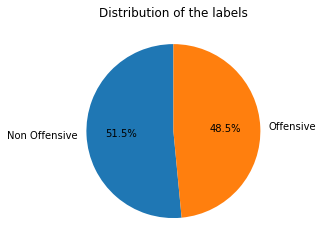

In [3]:
display(data.head())

print("Number of tweets:", len(data))
print("Distribution of the labels:")
print(data.Label.value_counts())
plt.pie(list(data.Label.value_counts()/len(data.Label)), startangle=90, labels = ['Non Offensive', 'Offensive'], autopct='%1.1f%%')
plt.title('Distribution of the labels')
plt.show()

## Defining $x$ and $y$, and then deviding them in training, validation and testing set

The column `Tweet` is the content (text) of tweets so it is the festures of data), and the column `Label` demonstrates the categories of those tweets. 
We, first split the whole data into two dataset : `train set` (15075 rows) and `test set` (0.15 of the data (2661 rows) that will be used to evaluate the performance of the models (classifiers) on unseen data by predicting their labels), then we split the Train set into two subsets : `train set` (used to train the model) and  `val set`( 0.18 of the train set from the first split = 2714).

At the end, we have set a grid search using `PredifinedSplit` method from `sklean` by defining the index `0` for `validation set` and `-1` for `train set`




In [4]:
x = data.Tweet.to_numpy()
y = data.Label.to_numpy()

X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.15, shuffle = True, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.18, shuffle=True, random_state = 42)

split_index = [-1 if elem in x_train else 0 for elem in X_train]  # implementing a grid search using PredefinedSplit method 
ps = PredefinedSplit(test_fold = split_index)

# Using *TfidfVectorizer* 

Since the Machine Learning algorithms deal with numbers and take vectors of numeric features, we need to transform the text data into numeric vactors to be able to use it in these algorithms; for this purpose, we defined a vectorizer using the `TfidfVectorizer` method from `sklearn` library to extract the features from the text (`tf-idf` means term-frequency times inverse document-frequency, and the goal of using this method is to scale down the impact of tokens that occur very frequently in a given corpus(set) and that empirically provides less information than features that occur in a small fraction of the training corpus).  

The `EnglishStemmer` method form `nltk` libarry (a Natural Language Processing libarary to process the text data) helped us stem the words to their root so instead of processing different type of a word (containing prefix, suffix, ...), it deals with just the root.

A function also is defined to remove the `stop words`, because by removing these frequently used words, the focus will be given to the words the define the meaning of the text.Therefore, after defining the stopwords using `nltk` library, we remove them from the text using `EnglishStemmer` method.


In [5]:
vectorizer = TfidfVectorizer(strip_accents = 'ascii', preprocessor = None)   #define vectorizer

stemmer = EnglishStemmer()                                                   #define stemmer

english_stopwords = set(stopwords.words('english'))                          # define the stopwords using the stopwords methods in Nltk library 

#functions for stemming
def stemming_tokenizer(text):
	# stemming each word to its root by removing the prefix and suffix  
	stemmed_text = [stemmer.stem(word) for word in word_tokenize(text, language='english')]
	return stemmed_text

def stemming_stop_tokenizer(text):
	# removing the stop words
	stemmed_text = [stemmer.stem(word) for word in word_tokenize(text, language='english') if word not in english_stopwords]
	return stemmed_text
#dictionary containing configuration
conf = {'vect__tokenizer': [None, stemming_tokenizer, stemming_stop_tokenizer], 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vect__min_df': [0.0, 0.1, 0.2]}


## Defining the classifiers and their paramenters

After importing the classifier from `sklearn` library,here we define each of them by setting the its main parameter. We have used numbers of classifier to compare their performance in analysing text data using different hypeparameters.

List of used Classifiers:

- `The multinomial Naive Bayes classifier` is normally used with disceret features, but it also works well on fractional feature (tf-idf features)

- `KNeighborsClassifier` 
- `Support Vector Machine`
- `DecisionTreeClassifier`
- `RandomForestClassifier`
- `LogisticRegression`
- `GradientBoostingClassifier`


In [6]:
MNB = MultinomialNB()
KNN = KNeighborsClassifier(n_jobs = -1)
SVM = SVC(random_state = 42)
DT = DecisionTreeClassifier(random_state = 42)
RF = RandomForestClassifier(random_state = 42)
LR = LogisticRegression(random_state = 42)
GBC = GradientBoostingClassifier(random_state = 42)

MNB_param = {'MNB__alpha': [0.01, 0.1, 1.0]}    
KNN_param = {'KNN__n_neighbors': [3, 5, 10]}
SVM_param = {'SVM__kernel': ['poly', 'sigmoid']}
DT_param = {'DT__criterion': ['gini', 'entropy']}
RF_param = {'RF__criterion': ['gini', 'entropy']}
LR_param = {'LR__penalty': ['l1', 'l2', 'elasticnet', 'none']}
GBC_param = {'GBC__loss': ['log_loss', 'exponential'], 'GBC__learning_rate': [0.1, 0.01, 0.001]}

## Performing a randomized search for each classifier

After defining the classsifiers and setting a range for their parameter, we have made a pipeline for each model applying a grid search to find the best parameter. In the grid search and for each model, we compare the `f1` score derived from different values for the parameter using the data split that is done using `PredifinedSplit` method.

In [7]:
grid_search = {} 

# make pipeline for MNB
pipeline= Pipeline([
	('vect', vectorizer),
	('MNB', MNB),
	])

parameters = {**conf, **MNB_param} #union of the dicts

grid_search['MNB'] = RandomizedSearchCV(pipeline, parameters, scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['MNB'].fit(X_train, Y_train)


# make pipeline for KNN
pipeline = Pipeline([
	('vect', vectorizer),
	('KNN', KNN),
	])

parameters = {**conf, **KNN_param}

grid_search['KNN'] = RandomizedSearchCV(pipeline, parameters,  scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['KNN'].fit(X_train, Y_train)

# make pipeline for SVM
pipeline = Pipeline([
	('vect', vectorizer),
	('SVM', SVM),
	])

parameters = {**conf, **SVM_param}

grid_search['SVM'] = RandomizedSearchCV(pipeline, parameters,  scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['SVM'].fit(X_train, Y_train)


# make pipeline for DT
pipeline = Pipeline([
	('vect', vectorizer),
	('DT', DT),
	])

parameters = {**conf, **DT_param}

grid_search['DT'] = RandomizedSearchCV(pipeline, parameters,  scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['DT'].fit(X_train, Y_train)

# make pipeline for RF
pipeline = Pipeline([
	('vect', vectorizer),
	('RF', RF),
	])

parameters = {**conf, **RF_param}

grid_search['RF'] = RandomizedSearchCV(pipeline, parameters,  scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['RF'].fit(X_train, Y_train)

# make pipeline for LR
pipeline= Pipeline([
	('vect', vectorizer),
	('LR', LR),
	])

parameters = {**conf, **LR_param} #union of the dicts

grid_search['LR'] = RandomizedSearchCV(pipeline, parameters, scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['LR'].fit(X_train, Y_train)

# make pipeline for GBC
pipeline= Pipeline([
	('vect', vectorizer),
	('GBC', GBC),
	])

parameters = {**conf, **GBC_param} #union of the dicts

grid_search['GBC'] = RandomizedSearchCV(pipeline, parameters, scoring = 'f1',
                                     cv = ps, n_iter = 15, verbose = -1, random_state = 42)

grid_search['GBC'].fit(X_train, Y_train)

/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0, -1])),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(strip_accents='ascii')),
                                             ('GBC',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=15,
                   param_distributions={'GBC__learning_rate': [0.1, 0.01,
                                                               0.001],
                                        'GBC__loss': ['log_loss',
                                                      'exponential'],
                                        'vect__min_df': [0.0, 0.1, 0.2],
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3)],
                                        'vect__tokenizer': [None,
                                                            <function stemming_tokenizer at 0x7fc085981d80>,
                                                            <function stemming_stop_tokenizer at 0x7fc085981ea0>]},
                   random_state=42, scoring='f1', verbose=-1)

## Plotting the results
Here, we show the best results of each classifier that is obtained from the grid serach using the best parameters, and by looking at the result we can see that the SVM classifier performed better than the other classifier by acheiving the highest f1 score (90%). It means the SVM model classified 90% of test data correctly. 

In [8]:
for classifier in grid_search:
    pred = grid_search[classifier].predict(x_test)
    print("Scores", classifier+":")
    print(metrics.classification_report(y_test, pred, target_names = ["Non offensive", "Offensive"]))
    print()
    print("Confusion Matrix", classifier+":")
    display(pd.DataFrame(metrics.confusion_matrix(y_test, pred)))
    print()
    print()
    print()

Scores MNB:
               precision    recall  f1-score   support

Non offensive       0.84      0.80      0.82      1361
    Offensive       0.80      0.84      0.82      1300

     accuracy                           0.82      2661
    macro avg       0.82      0.82      0.82      2661
 weighted avg       0.82      0.82      0.82      2661


Confusion Matrix MNB:


,0,1
0,1092,269
1,212,1088





Scores KNN:
               precision    recall  f1-score   support

Non offensive       0.80      0.74      0.77      1361
    Offensive       0.75      0.80      0.77      1300

     accuracy                           0.77      2661
    macro avg       0.77      0.77      0.77      2661
 weighted avg       0.77      0.77      0.77      2661


Confusion Matrix KNN:


,0,1
0,1004,357
1,256,1044





Scores SVM:
               precision    recall  f1-score   support

Non offensive       0.91      0.89      0.90      1361
    Offensive       0.89      0.91      0.90      1300

     accuracy                           0.90      2661
    macro avg       0.90      0.90      0.90      2661
 weighted avg       0.90      0.90      0.90      2661


Confusion Matrix SVM:


,0,1
0,1210,151
1,115,1185





Scores DT:
               precision    recall  f1-score   support

Non offensive       0.89      0.87      0.88      1361
    Offensive       0.87      0.89      0.88      1300

     accuracy                           0.88      2661
    macro avg       0.88      0.88      0.88      2661
 weighted avg       0.88      0.88      0.88      2661


Confusion Matrix DT:


,0,1
0,1186,175
1,147,1153





Scores RF:
               precision    recall  f1-score   support

Non offensive       0.88      0.90      0.89      1361
    Offensive       0.89      0.87      0.88      1300

     accuracy                           0.88      2661
    macro avg       0.88      0.88      0.88      2661
 weighted avg       0.88      0.88      0.88      2661


Confusion Matrix RF:


,0,1
0,1221,140
1,170,1130





Scores LR:
               precision    recall  f1-score   support

Non offensive       0.88      0.89      0.89      1361
    Offensive       0.89      0.87      0.88      1300

     accuracy                           0.88      2661
    macro avg       0.88      0.88      0.88      2661
 weighted avg       0.88      0.88      0.88      2661


Confusion Matrix LR:


,0,1
0,1214,147
1,164,1136





Scores GBC:
               precision    recall  f1-score   support

Non offensive       0.88      0.89      0.88      1361
    Offensive       0.88      0.88      0.88      1300

     accuracy                           0.88      2661
    macro avg       0.88      0.88      0.88      2661
 weighted avg       0.88      0.88      0.88      2661


Confusion Matrix GBC:


,0,1
0,1205,156
1,160,1140


# Transformers encoding

## Downloading *all-distilroberta-v1* and perform a grid search for each classifier

Here, we have used a specific kind of encoding method called `transformers encoding` (or `positional encoding`). In this method, the information regarding the position of an object in a series is maintained, and since the position of a word can affect the meaning of the sentence, by using this encoding method we can retain and use this valuable information. The positional encoding assign each position or index to a vector so the output of this encoding is a matrix. This method is applied using `sentences_transformer` library and the resulted data is a matrix with 768 dimensions, which is hard to be processed. Therefore, a PCA algorith is used to reduced these dimensions, then the compressed data is used to train our clasifiers by applying a grid search to find the best combination of parameters with the highest `f1 score`.       

In [9]:
MNB_param = {'alpha': [0.01, 0.1, 1.0]}    
KNN_param = {'n_neighbors': [3, 5, 10]}
SVM_param = {'kernel': ['poly', 'sigmoid']}
DT_param = {'criterion': ['gini', 'entropy']}
RF_param = {'criterion': ['gini', 'entropy']}
LR_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none']}
GBC_param = {'loss': ['log_loss', 'exponential'], 'learning_rate': [0.1, 0.01, 0.001]}

# We donwload a new pretrained model
model = SentenceTransformer('all-distilroberta-v1')

# We encode the sets
embeddings_train = model.encode(list(X_train))
embeddings_test = model.encode(list(x_test))

# We run the PCA
pca = PCA(0.95, random_state = 42)
pca.fit(embeddings_train)
print("Number of components of the pca:", pca.n_components_)
# We transfrom the data using the PCA
embeddings_train = pca.transform(embeddings_train)
embeddings_test = pca.transform(embeddings_test)

# A dictionary with the classifiers
classifiers = {'SVM': GridSearchCV(SVC(random_state = 42), SVM_param,  scoring = 'f1', cv = ps, verbose = -1),
               'KNN': GridSearchCV(KNeighborsClassifier(), KNN_param,  scoring = 'f1', cv = ps, verbose = -1),
               'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state = 42), DT_param,  scoring = 'f1', cv = ps, verbose = -1),
               'RandomForest': GridSearchCV(RandomForestClassifier(random_state = 42), RF_param,  scoring = 'f1', cv = ps, verbose = -1),
               'LogisticRegression': GridSearchCV(LogisticRegression(random_state = 42), LR_param,  scoring = 'f1', cv = ps, verbose = -1),
               'GradientBoostingClassifier': GridSearchCV(GradientBoostingClassifier(random_state = 42), GBC_param,  scoring = 'f1', cv = ps, verbose = -1)
               }

best_clf = None
best_f1 = 0
current_f1 = 0

for classifier in classifiers:
    classifiers[classifier].fit(embeddings_train, Y_train)
    current_f1 = classifiers[classifier].best_score_

    if best_f1 < current_f1:
        best_f1 = current_f1
        best_clf = classifier

Number of components of the pca: 384


/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/jrhin/Uni/sl/slenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 61, in 

## Print the results
The results of classifiers trained by encoded data is shown bellow, and similar to the previous training, the Support Vector Machine classifier had a better performance with 90% `f1 score` comparing to the other classifiers. But, as we can see the model resulted in a better performance without `transformer encoding`, which is considered to be suprising due the fact that `positional encoding` is a powerful tool to retain valuable information.

In [10]:
for classifier in classifiers:
    pred = classifiers[classifier].predict(embeddings_test)
    print("Scores", classifier+":")
    print(metrics.classification_report(y_test, pred, target_names = ["Non offensive", "Offensive"]))
    print()
    print("Confusion Matrix", classifier+":")
    display(pd.DataFrame(metrics.confusion_matrix(y_test, pred)))
    print()
    print()
    print()

Scores SVM:
               precision    recall  f1-score   support

Non offensive       0.88      0.85      0.86      1361
    Offensive       0.85      0.88      0.86      1300

     accuracy                           0.86      2661
    macro avg       0.86      0.86      0.86      2661
 weighted avg       0.86      0.86      0.86      2661


Confusion Matrix SVM:


,0,1
0,1151,210
1,155,1145





Scores KNN:
               precision    recall  f1-score   support

Non offensive       0.82      0.82      0.82      1361
    Offensive       0.81      0.81      0.81      1300

     accuracy                           0.81      2661
    macro avg       0.81      0.81      0.81      2661
 weighted avg       0.81      0.81      0.81      2661


Confusion Matrix KNN:


,0,1
0,1112,249
1,245,1055





Scores DecisionTree:
               precision    recall  f1-score   support

Non offensive       0.72      0.71      0.72      1361
    Offensive       0.70      0.71      0.70      1300

     accuracy                           0.71      2661
    macro avg       0.71      0.71      0.71      2661
 weighted avg       0.71      0.71      0.71      2661


Confusion Matrix DecisionTree:


,0,1
0,973,388
1,383,917





Scores RandomForest:
               precision    recall  f1-score   support

Non offensive       0.79      0.83      0.81      1361
    Offensive       0.81      0.77      0.79      1300

     accuracy                           0.80      2661
    macro avg       0.80      0.80      0.80      2661
 weighted avg       0.80      0.80      0.80      2661


Confusion Matrix RandomForest:


,0,1
0,1123,238
1,298,1002





Scores LogisticRegression:
               precision    recall  f1-score   support

Non offensive       0.85      0.85      0.85      1361
    Offensive       0.84      0.84      0.84      1300

     accuracy                           0.85      2661
    macro avg       0.85      0.85      0.85      2661
 weighted avg       0.85      0.85      0.85      2661


Confusion Matrix LogisticRegression:


,0,1
0,1158,203
1,207,1093





Scores GradientBoostingClassifier:
               precision    recall  f1-score   support

Non offensive       0.84      0.82      0.83      1361
    Offensive       0.81      0.83      0.82      1300

     accuracy                           0.82      2661
    macro avg       0.82      0.83      0.82      2661
 weighted avg       0.83      0.82      0.82      2661


Confusion Matrix GradientBoostingClassifier:


,0,1
0,1112,249
1,217,1083
